# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# We have divided the project into 4 parts
1. Data Pre-processing
2. EDA
3. Feature Engineering
4. Model

# 1.1 Lets equip all the necessary tools

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

# 1.2 Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path_store_csv = "/content/drive/MyDrive/Colab Notebooks/almabetter pro materials/Capstone Projects/My Capstone Projects/Rossman stores sales prediction/store.csv"
store_df = pd.read_csv(path_store_csv)

path_sales_csv = "/content/drive/MyDrive/Colab Notebooks/almabetter pro materials/Capstone Projects/My Capstone Projects/Rossman stores sales prediction/Rossmann Stores Data.csv"
sales_df = pd.read_csv(path_sales_csv, parse_dates = ['Date'])

#1.3  Data Cleaning

In [ ]:
# Taking a glance on the datasets
print("no of observations & no of features", sales_df.shape)
sales_df.head()

no of observations & no of features (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


Great!! There are no missing values here

In [ ]:
sales_df['Date'].sort_values()

1017208   2013-01-01
1016473   2013-01-01
1016472   2013-01-01
1016471   2013-01-01
1016470   2013-01-01
             ...    
745       2015-07-31
746       2015-07-31
747       2015-07-31
741       2015-07-31
0         2015-07-31
Name: Date, Length: 1017209, dtype: datetime64[ns]

In [ ]:
sales_df['Date'].value_counts()

2015-07-31    1115
2013-11-06    1115
2013-11-18    1115
2013-11-17    1115
2013-11-16    1115
              ... 
2014-10-28     935
2014-10-27     935
2014-10-26     935
2014-10-25     935
2014-12-08     935
Name: Date, Length: 942, dtype: int64

In [ ]:
# Grouping by date
sales_df.groupby(['Store'])['Date'].count().reset_index().groupby(['Date'])["Store"].count().reset_index()

,Date,Store
0,758,180
1,941,1
2,942,934


We have store sales data for 942 days for 934 stores out of 1115 while for 180 stores we only have 758 days of sales data

In [ ]:
# Store open/close
sales_df['Open'].value_counts()

1    844392
0    172817
Name: Open, dtype: int64

In [ ]:
# Lets look at the stores dataset
print("no of observations & no of features", store_df.shape)
store_df.head()

no of observations & no of features (1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [ ]:
store_df[store_df['CompetitionDistance'].isna()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [ ]:
#Counting missing values in the dataset

print('store_df :\n\n', store_df.isnull().sum())

store_df :

 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


Text(0.5, 1.0, 'Distributin of Store Competition Distance')

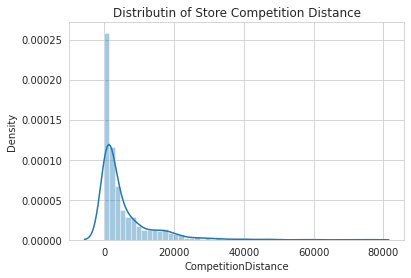

In [ ]:
# CompetitionDistance is distance in meters to the nearest competitor store
# Let's first have a look at its distribution
sns.distplot(store_df.CompetitionDistance)
plt.title("Distributin of Store Competition Distance")

Replacing the missing values with median would be a good choice

In [ ]:
# Replace missing values in CompetitionDistance with median for the store dataset
store_df.CompetitionDistance.fillna(store_df.CompetitionDistance.median(), inplace=True)


In [ ]:
# Lets merge both the files
df=pd.merge(sales_df,store_df,how='left',on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [ ]:
# Lets get year, month, date from current date

def GetYear(date):
  return date.year

def GetMonth(date):
  return date.month

def GetDay(date):
  return date.day



df['Year'] = df['Date'].apply(GetYear)
df['Month'] = df['Date'].apply(GetMonth)
df['Day'] = df['Date'].apply(GetDay)

In [ ]:
# Function to get competition age
def GetCompetitionAge(year,month,date):

  #Initiating with a variable for age
  age=0

  # Comparing the Competition open time with current time
  if date.year>year:
    age+= (date.year-year)*12 + (date.month - month)

  elif date.year == year and date.month>month:
    age+= date.month - month

  return age

In [ ]:
df['CompetitionAge'] = df.apply(lambda x: GetCompetitionAge(x.CompetitionOpenSinceYear, x.CompetitionOpenSinceMonth,x.Date), axis=1)

In [ ]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,92.0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,103.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0


In [ ]:
# There are 3 types of intervals followed by different stores indicating the month in which promo2 new rounf is started
# Lets generate a binary variable showing if new promo2 round is started in the current month or not

# String to List
df['PromoInterval'] = df['PromoInterval'].str.split(',')  

# Converting months into list of month numbers for easy comparison
def GetMonthNumber(month):
  month_dict = {'Jan':1,'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sept':9,'Oct':10,'Nov':11,'Dec':12}
  return month_dict[month]

def GetNumList(interval):
  numlist=[]
  for month in interval:
    month_num = GetMonthNumber(month)
    numlist.append(month_num)
  return numlist  

In [ ]:
print(df['PromoInterval'][1], '\n' ,
      GetNumList(df['PromoInterval'][1]))

['Jan', 'Apr', 'Jul', 'Oct'] 
 [1, 4, 7, 10]


In [ ]:
# Function to check promo2 new round

def IsPromo2NewRound(promo_part,promo_year,promo_week,promo_interval,date):

  # Initiating a variable if promo is active
  promo_active = 0
  # Initiating a variable if promo new round is active
  promo_new= 0

  # Taking only stores that are participating in promo2
  if promo_part == 1:
    # Checking if the promo has been activated
    if date.year == promo_year and date.week >= promo_week :
      promo_active = 1

    elif date.year > promo_year :
      promo_active = 1

    if promo_active == 1:
      
      #Getting month_number for easy comparison
      promo_months = GetNumList(promo_interval)
      #Checking if new round is started in current month
      if date.month in promo_months:
        promo_new = 1

  return promo_new

In [ ]:
df['Promo2New'] = df.apply( lambda x : IsPromo2NewRound(x.Promo2,x.Promo2SinceYear,x.Promo2SinceWeek,x.PromoInterval,x.Date),axis=1)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,CompetitionAge,Promo2New
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,2008.0,0,NaN,NaN,NaN,2015,7,31,82.0,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,2007.0,1,13.0,2010.0,"[Jan, Apr, Jul, Oct]",2015,7,31,92.0,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,2006.0,1,14.0,2011.0,"[Jan, Apr, Jul, Oct]",2015,7,31,103.0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,2009.0,0,NaN,NaN,NaN,2015,7,31,70.0,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,2015.0,0,NaN,NaN,NaN,2015,7,31,3.0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 23 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1017209 no

All null values are dealt with..
One step remains before we move on to EDA